In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

from importlib import import_module
from sklearn.model_selection import KFold
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
)
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import jaccard_score

# special imports
from datasets_utils.datasets import ABUS_dataset
sys.path.append(str(repo_path / 'SAMed')) if str(repo_path / 'SAMed') not in sys.path else None
from SAMed.segment_anything import sam_model_registry

# Inference of SAMed

## Setup

In [3]:
# HP
run_name = 'vanilla3'

# run path
weights_path = repo_path / f'experiments/SAMed_ABUS/weights/{run_name}'
dirs = os.listdir(weights_path)
dirs.sort() # sort by epoch
last_epoch = dirs[-1] # get last epoch
best_epoch = dirs[-2] # get best epoch

Model

In [25]:
# get SAM model
checkpoint_dir = repo_path / 'checkpoints'
sam, _ = sam_model_registry['vit_b'](image_size=256,
                                    num_classes=1,
                                    checkpoint=str(checkpoint_dir / 'sam_vit_b_01ec64.pth'),
                                    pixel_mean=[0, 0, 0],
                                    pixel_std=[1, 1, 1])
# load lora model
pkg = import_module('sam_lora_image_encoder')
model = pkg.LoRA_Sam(sam, 4)
# load weighs
# load_path = weights_path / best_epoch
load_path = repo_path / 'experiments/SAMed_ABUS/results/vanilla_1class/fold0/weights/epoch_26.pth'
model.load_lora_parameters(str(load_path))
model.eval()
model.to(device);

Data

In [26]:
# create fold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
for fold_n, (_, val_ids) in enumerate(kf.split(range(100))):
    break
print(f'The number of patients in the validation set is {len(val_ids)}')
print(f'The patient ids in the validation set are {val_ids}')
# transform
val_transform = Compose(
        [
            EnsureChannelFirstd(keys=['label'], channel_dim='no_channel'),

            ScaleIntensityd(keys=["image"]),

            Resized(keys=["image", "label"], spatial_size=(256, 256),mode=['area','nearest']),
            EnsureTyped(keys=["image"])
        ])

The number of patients in the validation set is 20
The patient ids in the validation set are [ 2  7  8 13 16 22 24 26 30 33 53 54 55 73 75 78 86 92 93 95]


In [27]:
# HP
batch_size = 1
multimask_output = True

pat_num = -1
pat_id = [val_ids[pat_num]]

# get data
root_path = repo_path / 'data/challange_2023/with_lesion'
path_images = (root_path / "image_mha")
path_labels = (root_path / "label_mha")
# get all files in the folder in a list, only mha files
image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
# now, we will check if the path has at least one of the ids in the train_ids list
val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
# create final paths
image_files = np.array([path_images / i for i in val_files])
label_files = np.array([path_labels / i for i in val_files])
list_val = [image_files, label_files] # this is what we will pass to the dataset <-

# define dataset and dataloader
db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
print(f'The number of slices is {len(db_val)}')

The number of slices is 24


/home/ricardo/ABUS2023_documents/tdsc_abus23/datasets_utils/datasets.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


## Evaluate

Jaccard score for slice 0 is 0.0
Jaccard score for slice 1 is 0.0
Jaccard score for slice 2 is 0.0
Jaccard score for slice 3 is 0.0
Jaccard score for slice 4 is 0.0
Jaccard score for slice 5 is 0.0
Jaccard score for slice 6 is 0.46445497630331756
Jaccard score for slice 7 is 0.42788461538461536
Jaccard score for slice 8 is 0.5781818181818181
Jaccard score for slice 9 is 0.657258064516129
Jaccard score for slice 10 is 0.6051873198847262
Jaccard score for slice 11 is 0.6648936170212766
Jaccard score for slice 12 is 0.6212534059945504
Jaccard score for slice 13 is 0.6837837837837838
Jaccard score for slice 14 is 0.717391304347826
Jaccard score for slice 15 is 0.7296587926509186
Jaccard score for slice 16 is 0.7471910112359551
Jaccard score for slice 17 is 0.6533742331288344
Jaccard score for slice 18 is 0.7509433962264151
Jaccard score for slice 19 is 0.7375565610859729
Jaccard score for slice 20 is 0.5547445255474452


/tmp/ipykernel_3954294/3724685155.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))


Jaccard score for slice 21 is 0.5054945054945055
Jaccard score for slice 22 is 0.0
Jaccard score for slice 23 is 0.0
Jaccard score for patient [95] is 0.5845697329376854


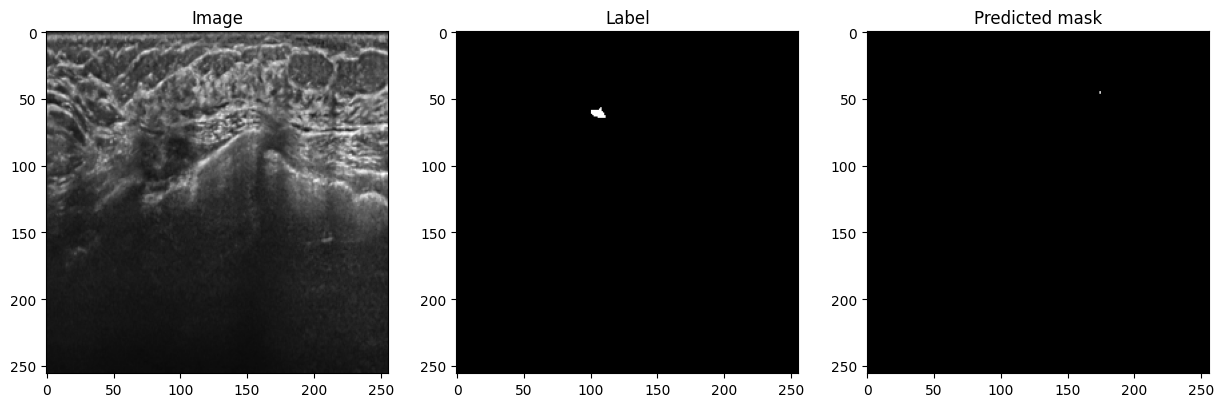

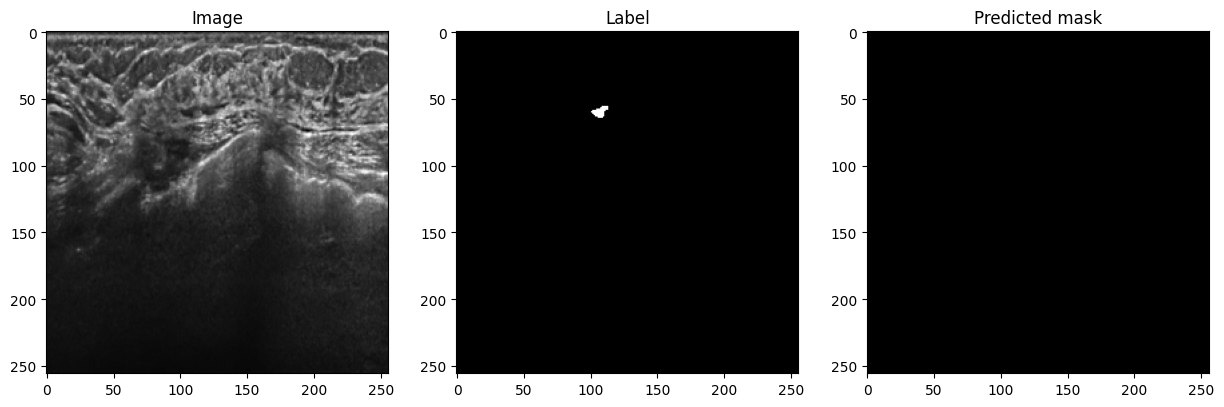

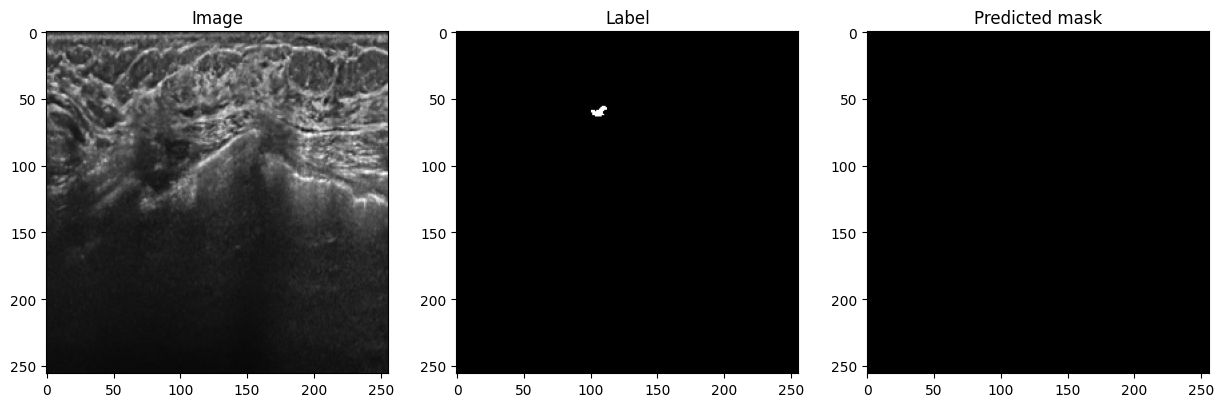

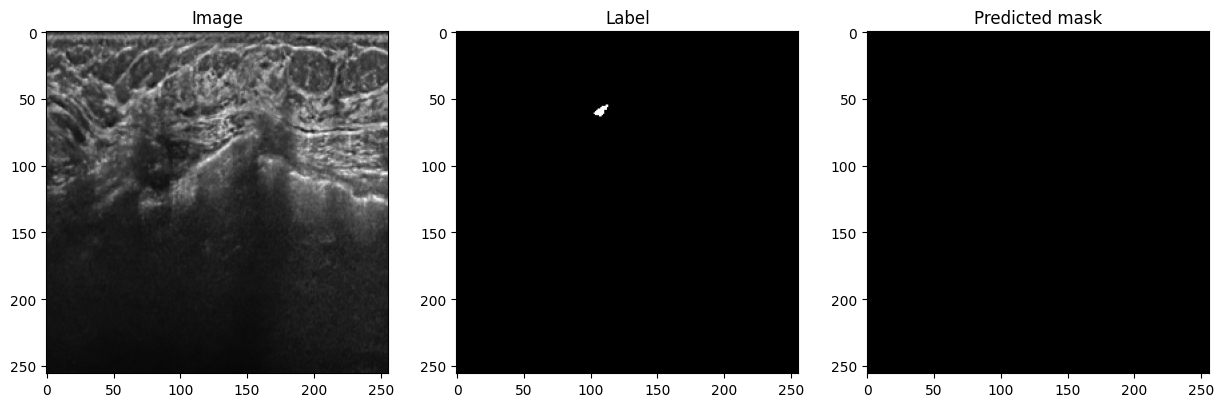

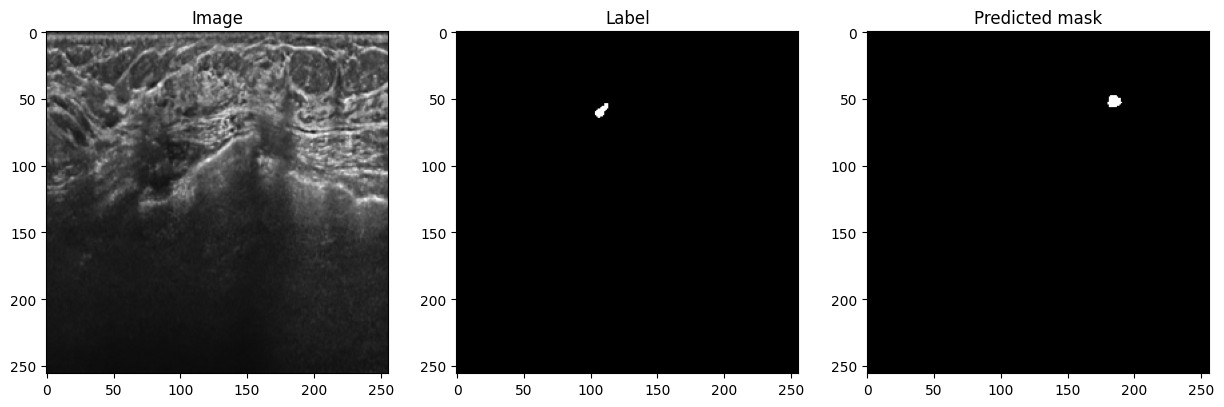

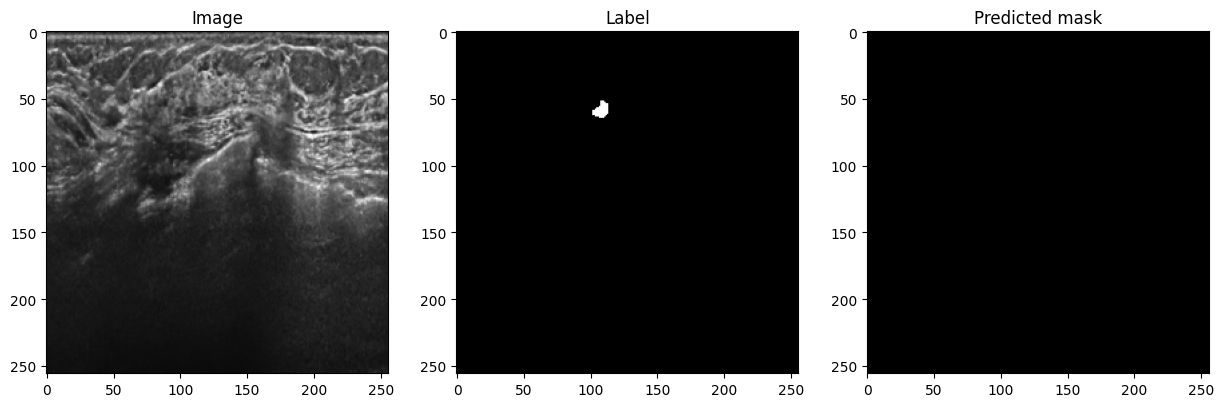

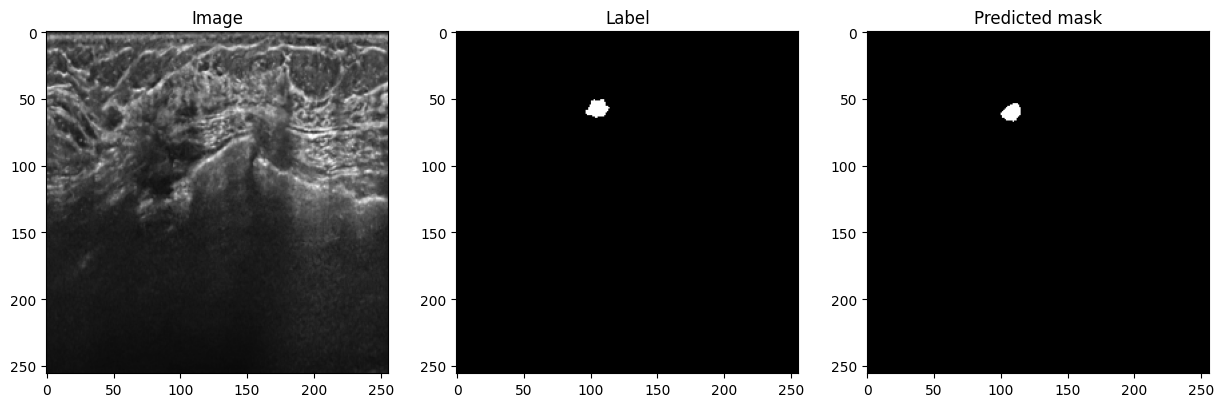

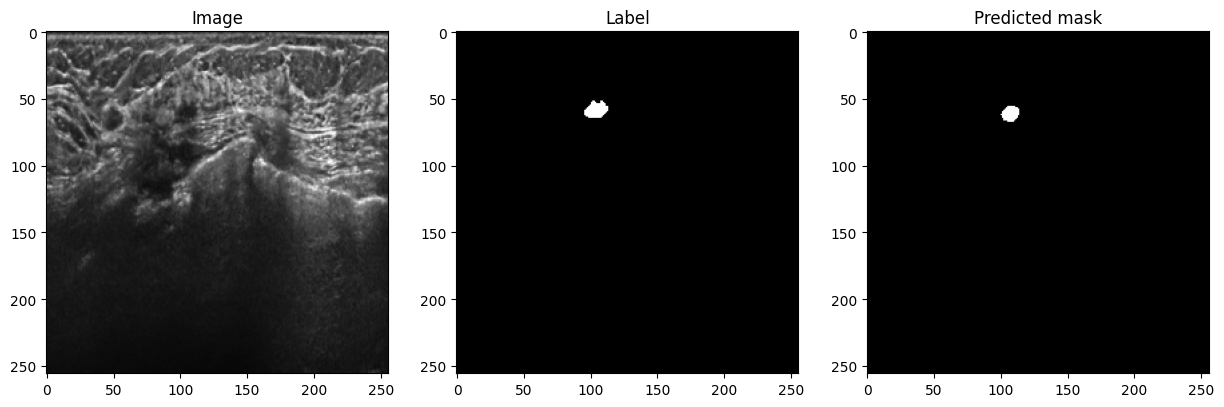

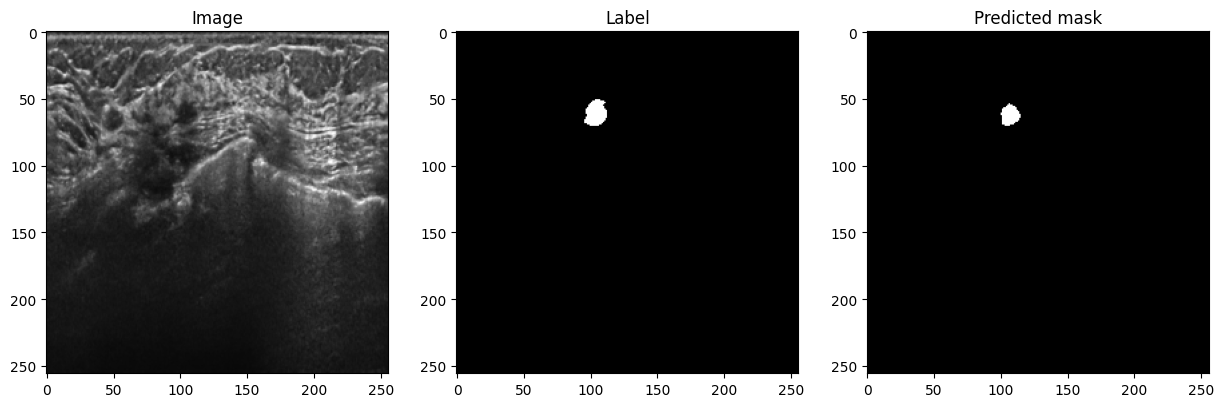

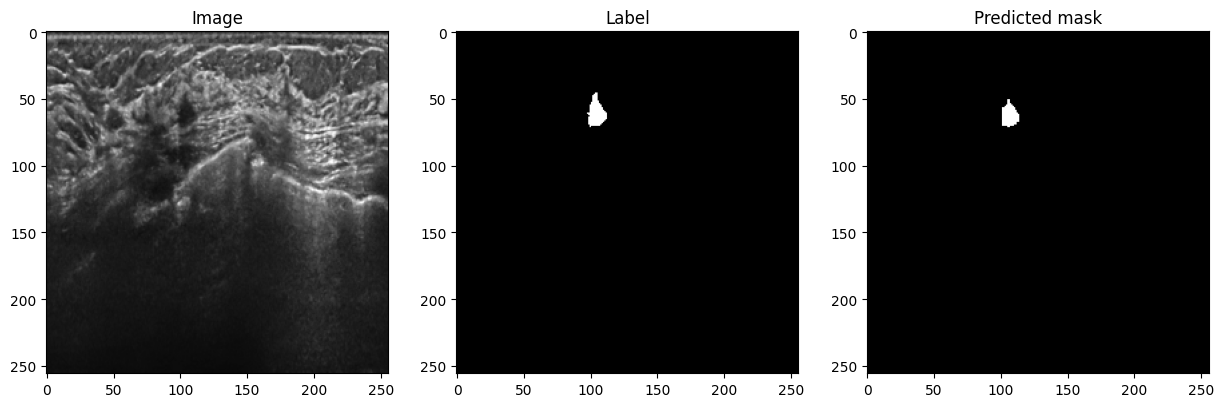

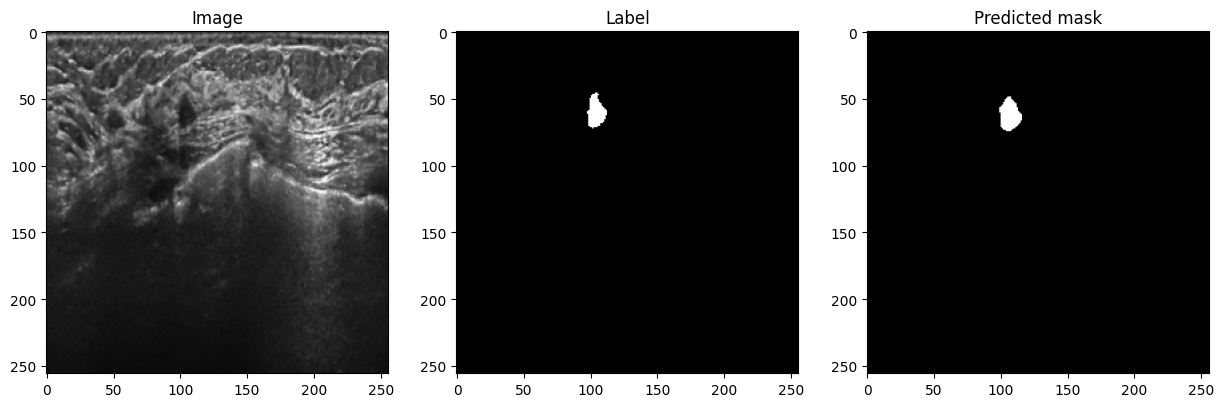

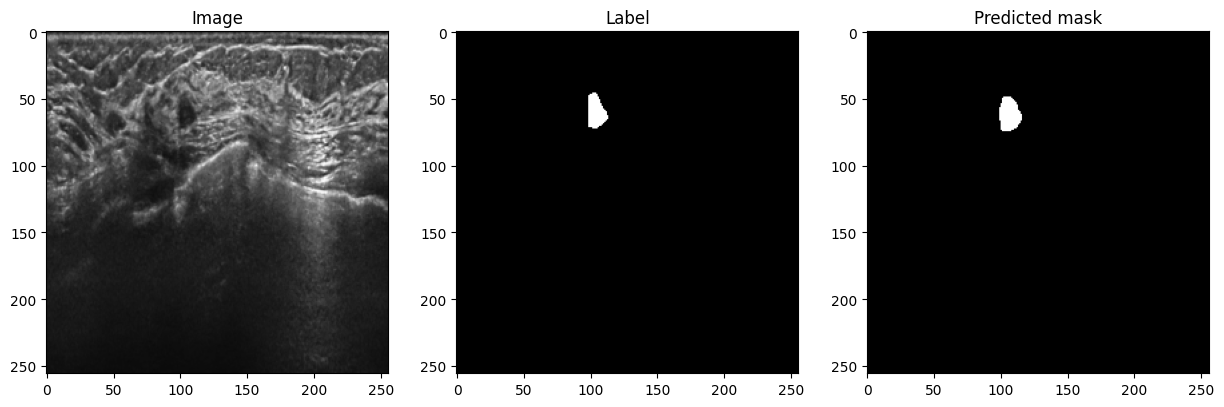

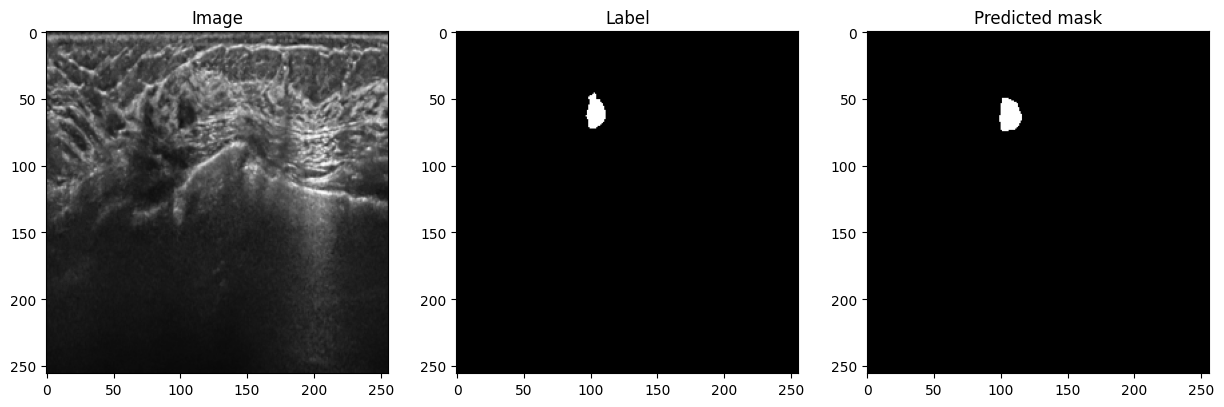

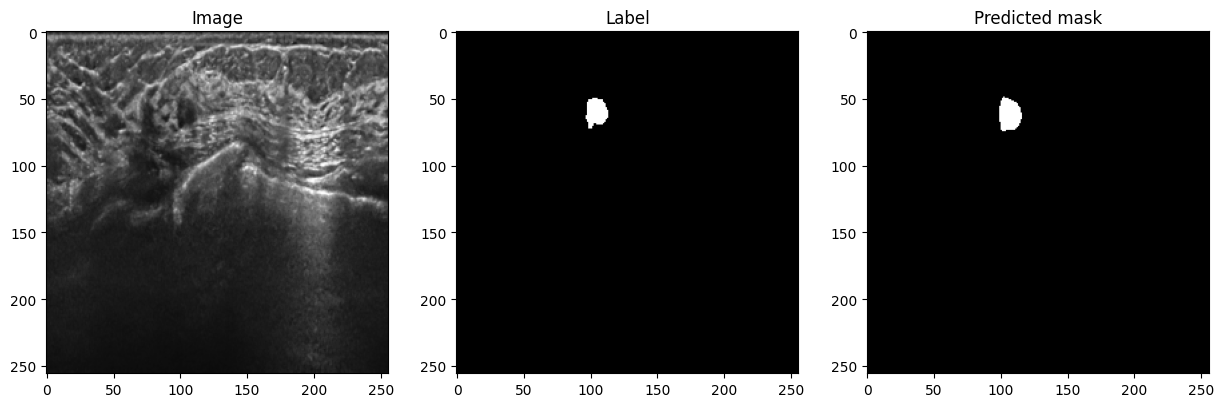

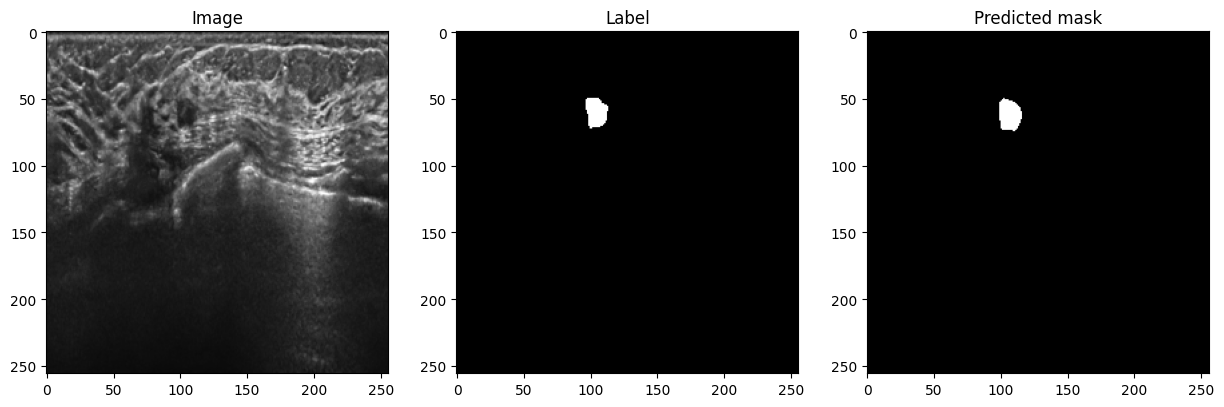

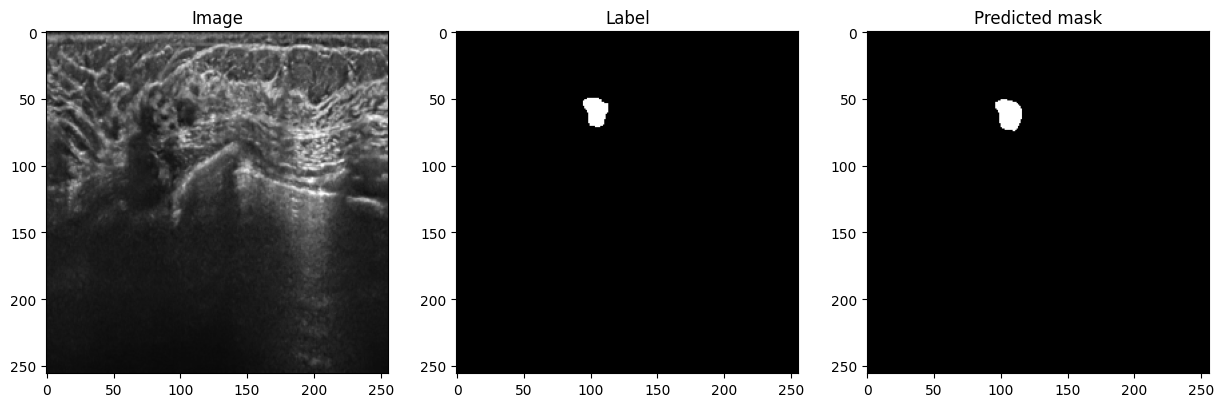

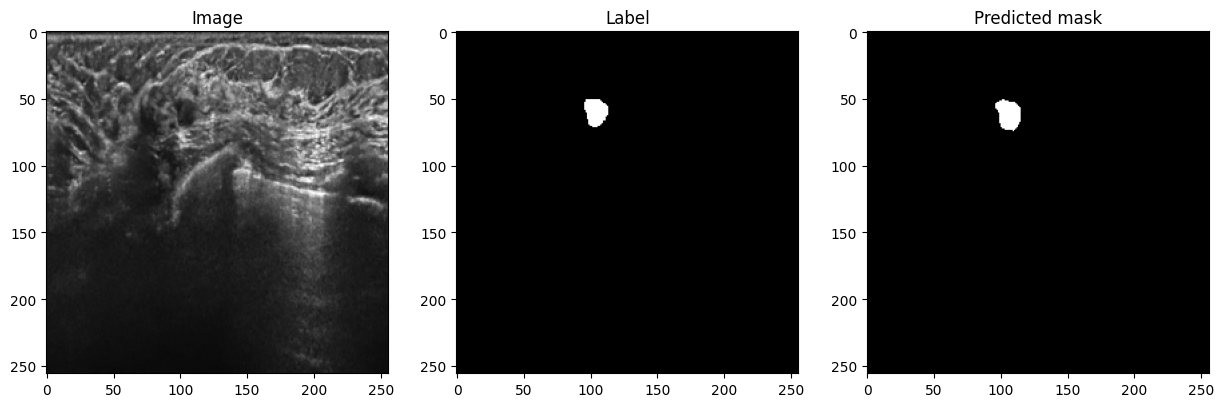

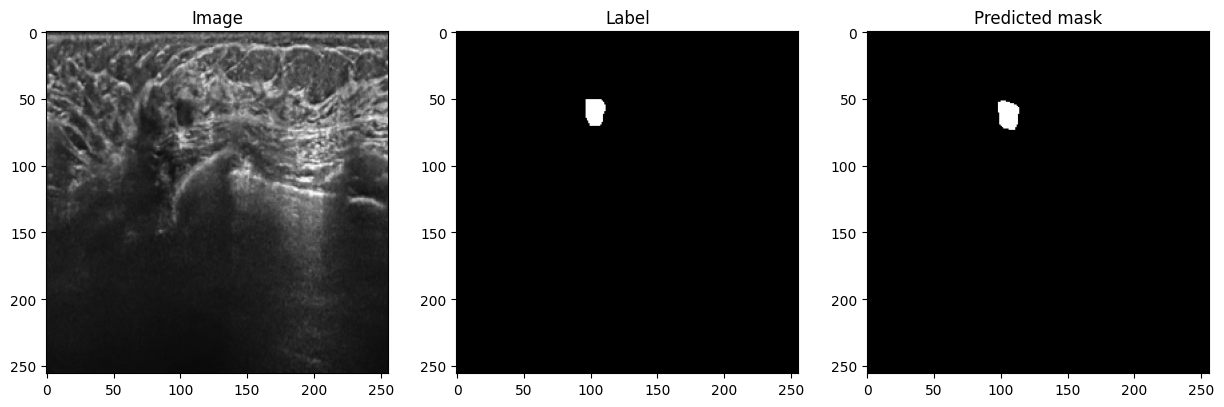

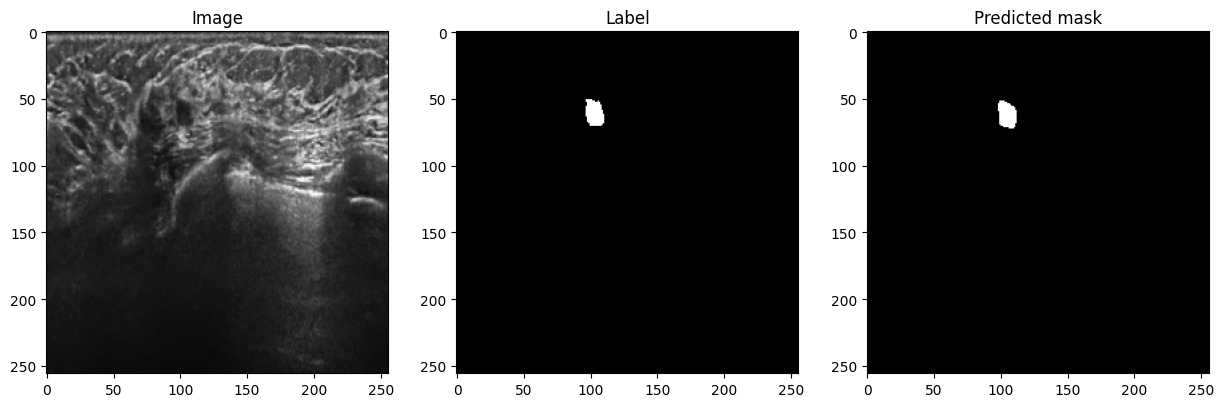

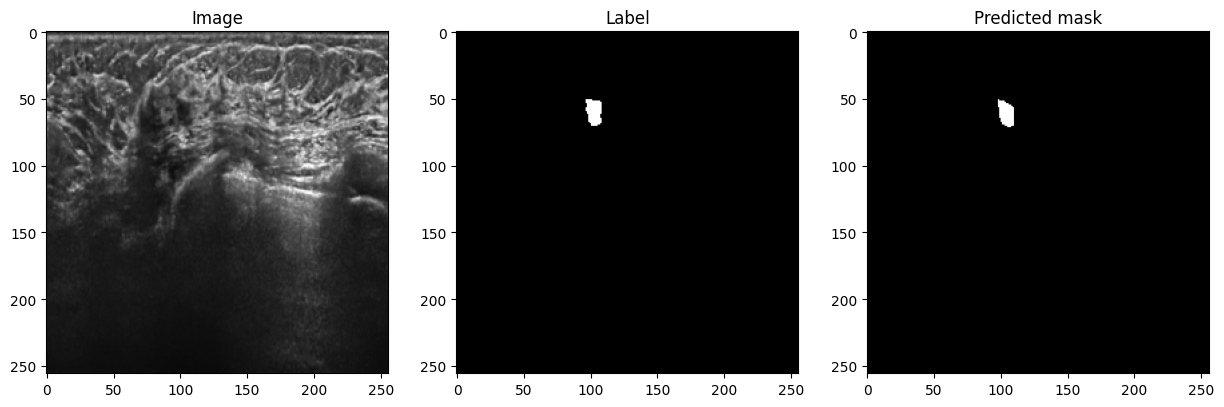

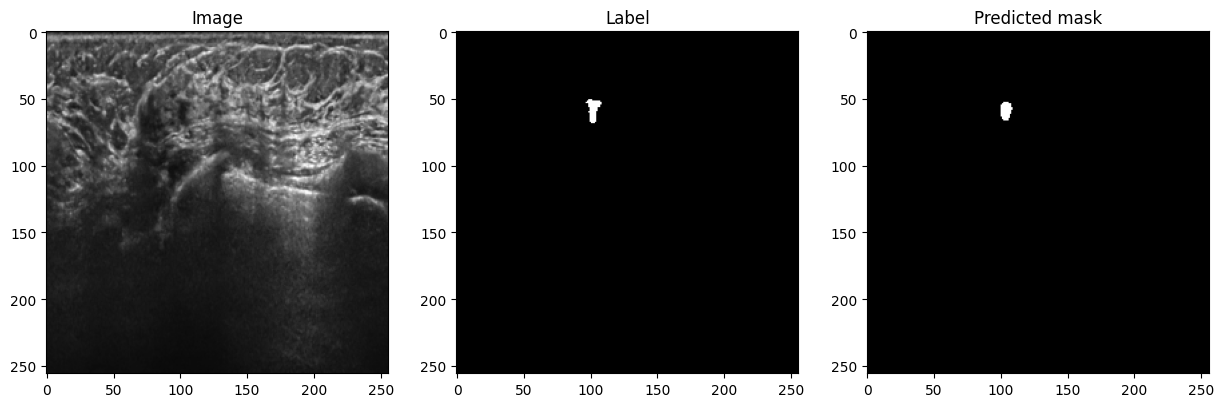

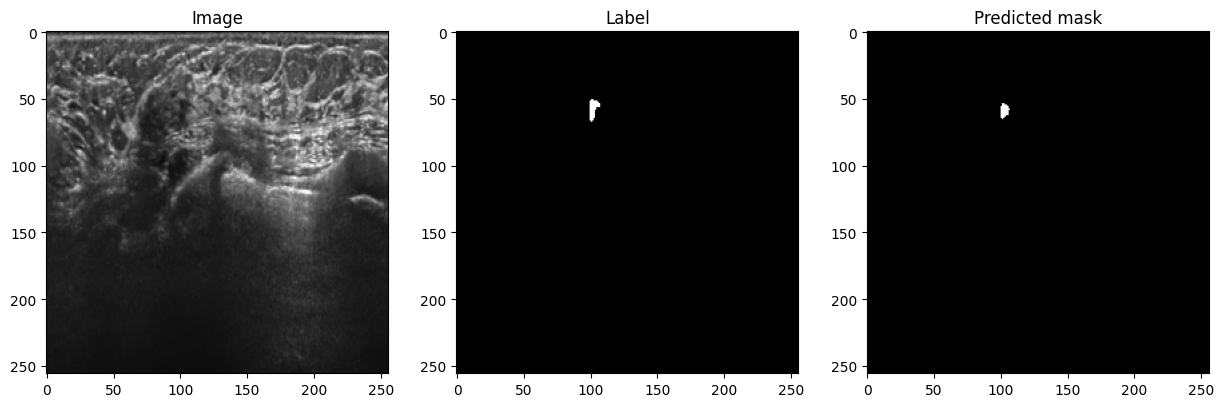

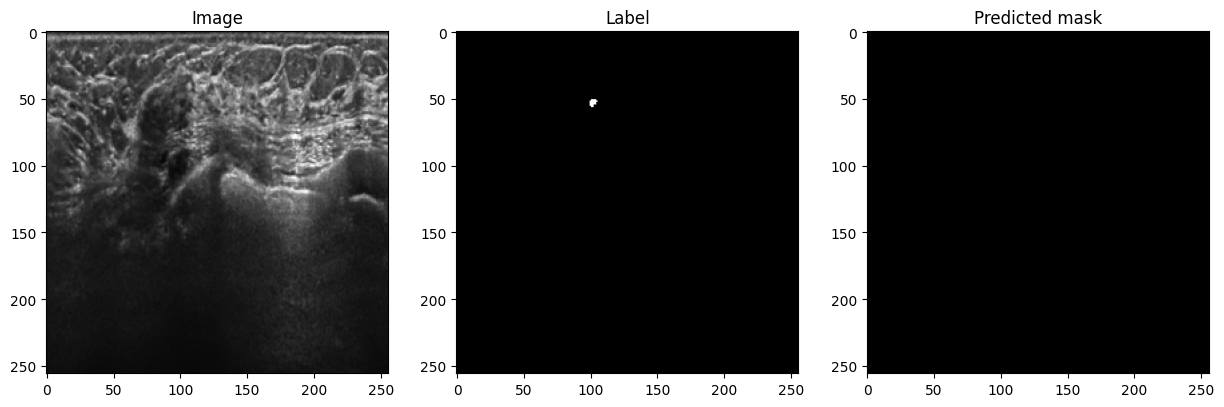

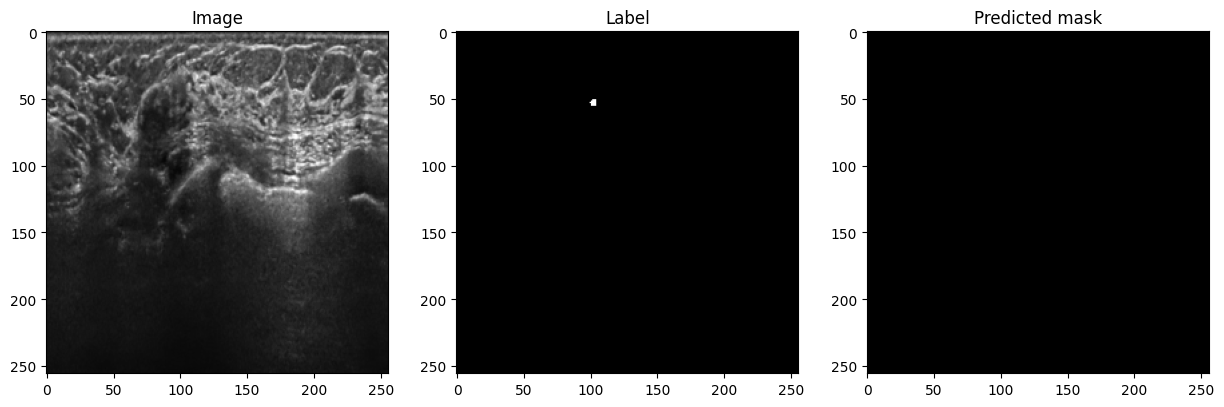

In [28]:
labels_array = np.zeros((len(db_val), 256, 256))
preds_array = np.zeros((len(db_val), 256, 256))
for batch_num, sample_batch in enumerate(valloader):
    # get data
    image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
    # forward and losses computing
    outputs = model(image_batch, multimask_output, 256)
    output_masks = outputs['masks'].detach().cpu()
    output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

    #label_batch and output_masks in array
    image_batch = image_batch[0, 0, :, :].cpu().numpy()
    label_batch = label_batch[0, :, :].cpu().numpy()
    output_masks = output_masks[0, 0, :, :].numpy()
    # save in array
    labels_array[batch_num, :, :] = label_batch
    preds_array[batch_num, :, :] = output_masks
    # slide jaccard score
    jaccard_value = jaccard_score(label_batch.flatten(), output_masks.flatten())
    
    print(f'Jaccard score for slice {batch_num} is {jaccard_value}')
    # show image, label and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_batch, cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(label_batch, cmap='gray')
    axs[1].set_title('Label')
    axs[2].imshow(output_masks, cmap='gray')
    axs[2].set_title('Predicted mask')
# get 3D jaccard score
jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
print(f'Jaccard score for patient {pat_id} is {jaccard_value}')

In [35]:
pure_output = outputs['low_res_logits'].detach().cpu()
pure_mask = outputs['masks'].detach().cpu()

Low resolution logits shape: torch.Size([1, 2, 64, 64])
Masks shape: torch.Size([1, 2, 256, 256])


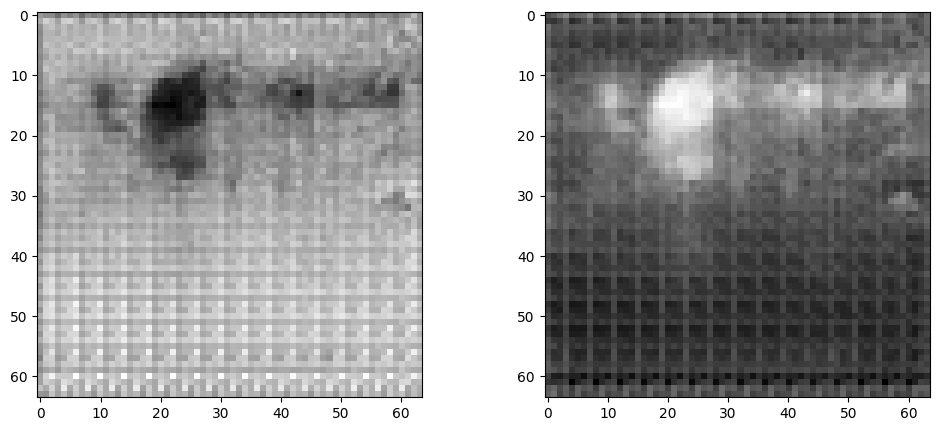

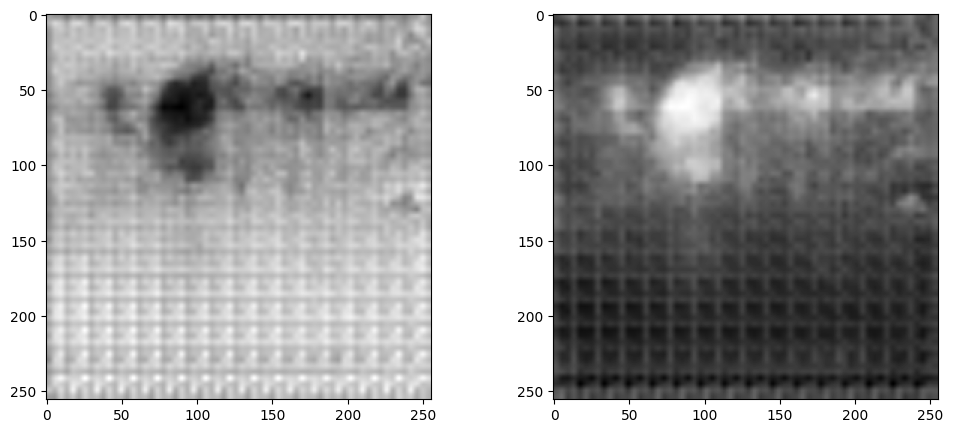

In [36]:
print(f'Low resolution logits shape: {pure_output.shape}')
fig, axs = plt.subplots(1, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[i].imshow(pure_output[0, i, :, :].numpy(), cmap='gray')
print(f'Masks shape: {pure_mask.shape}')
fig, axs = plt.subplots(1, pure_mask.shape[1], figsize=(12, 5))
for i in range(pure_mask.shape[1]):
    axs[i].imshow(pure_mask[0, i, :, :].numpy(), cmap='gray')

logits after softmax shape: torch.Size([1, 2, 64, 64])


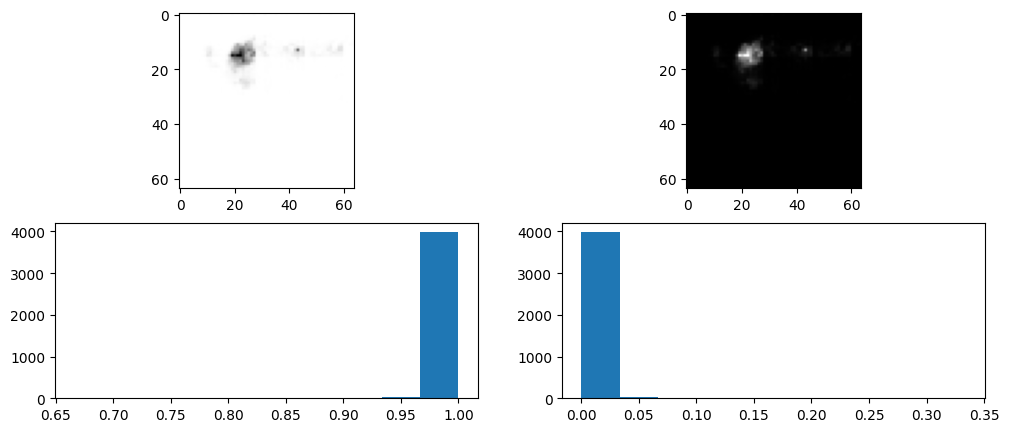

In [40]:
inputs = torch.softmax(pure_output, dim=1)
print(f'logits after softmax shape: {inputs.shape}')
fig, axs = plt.subplots(2, pure_output.shape[1], figsize=(12, 5))
for i in range(pure_output.shape[1]):
    axs[0,i].imshow(inputs[0, i, :, :].numpy(), cmap='gray')
    # histogram per image
    axs[1,i].hist(inputs[0, i, :, :].numpy().flatten())

## Full evaluation

In [63]:
# HP
batch_size = 1
multimask_output = True

patients_jaccard = np.zeros((len(val_ids), 2))
patients_dice = np.zeros((len(val_ids), 2))
for pat_num in range(len(val_ids)):
    pat_id = [val_ids[pat_num]]

    # get data
    root_path = repo_path / 'data/challange_2023/with_lesion'
    path_images = (root_path / "image_mha")
    path_labels = (root_path / "label_mha")
    # get all files in the folder in a list, only mha files
    image_files = sorted([file for file in os.listdir(path_images) if file.endswith('.mha')])
    # now, we will check if the path has at least one of the ids in the train_ids list
    val_files = [file for file in image_files if any(f'id_{id}_' in file for id in pat_id)]
    # create final paths
    image_files = np.array([path_images / i for i in val_files])
    label_files = np.array([path_labels / i for i in val_files])
    list_val = [image_files, label_files] # this is what we will pass to the dataset <-

    # define dataset and dataloader
    db_val = ABUS_dataset(transform=val_transform,list_dir=list_val)   
    valloader = DataLoader(db_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    print(f'The number of slices is {len(db_val)}')

    labels_array = np.zeros((len(db_val), 256, 256))
    preds_array = np.zeros((len(db_val), 256, 256))
    for batch_num, sample_batch in enumerate(valloader):
        # get data
        image_batch, label_batch = sample_batch["image"].to(device), sample_batch["label"].to(device)
        # forward and losses computing
        outputs = model(image_batch, multimask_output, 256)
        output_masks = outputs['masks'].detach().cpu()
        output_masks = torch.argmax(torch.softmax(output_masks, dim=1), dim=1, keepdim=True)

        #label_batch and output_masks in array
        image_batch = image_batch[0, 0, :, :].cpu().numpy()
        label_batch = label_batch[0, :, :].cpu().numpy()
        output_masks = output_masks[0, 0, :, :].numpy()
        # save in array
        labels_array[batch_num, :, :] = label_batch
        preds_array[batch_num, :, :] = output_masks
        
        # slice jaccard score
        # jaccard_slice = jaccard_score(label_batch.flatten(), output_masks.flatten())
        # print(f'Jaccard score for slice {batch_num} is {jaccard_slice}')
        # # show image, label and predicted mask
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # axs[0].imshow(image_batch, cmap='gray')
        # axs[0].set_title('Image')
        # axs[1].imshow(label_batch, cmap='gray')
        # axs[1].set_title('Label')
        # axs[2].imshow(output_masks, cmap='gray')
        # axs[2].set_title('Predicted mask')
    # get 3D jaccard score
    jaccard_value = jaccard_score(labels_array.flatten(), preds_array.flatten())
    # dice from jaccard
    dice_value = 2*jaccard_value/(1+jaccard_value)
    print(f'Jaccard score for patient {pat_id} is {jaccard_value}')
    print(f'Dice score for patient {pat_id} is {dice_value}')
    # store in array
    patients_jaccard[pat_num, 0] = pat_id[0]
    patients_jaccard[pat_num, 1] = jaccard_value
    patients_dice[pat_num, 0] = pat_id[0]
    patients_dice[pat_num, 1] = dice_value

The number of slices is 48


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [2] is 0.6972832785538209
Dice score for patient [2] is 0.8216463184011861
The number of slices is 14


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [7] is 0.5964895988112927
Dice score for patient [7] is 0.7472514687918097
The number of slices is 33


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [8] is 0.5206791754756871
Dice score for patient [8] is 0.6847981926402223
The number of slices is 14


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [13] is 0.6493761666175459
Dice score for patient [13] is 0.7874203347429864
The number of slices is 39


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [16] is 0.22636334696476235
Dice score for patient [16] is 0.3691619576286416
The number of slices is 55


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [22] is 0.5917768139532488
Dice score for patient [22] is 0.7435424473655257
The number of slices is 22


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [24] is 0.6831351021652943
Dice score for patient [24] is 0.8117412574741801
The number of slices is 35


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [26] is 0.4540365350618739
Dice score for patient [26] is 0.6245187436676799
The number of slices is 13


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [30] is 0.028642149929278642
Dice score for patient [30] is 0.055689240288759025
The number of slices is 41


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [33] is 0.7330296477332344
Dice score for patient [33] is 0.8459516531549492
The number of slices is 16


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [53] is 0.28369384359401
Dice score for patient [53] is 0.44199611147116014
The number of slices is 21


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [54] is 0.223455684870188
Dice score for patient [54] is 0.36528611151763496
The number of slices is 56


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [55] is 0.4588920059199046
Dice score for patient [55] is 0.6290966076417015
The number of slices is 19


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [73] is 0.0530550466024058
Dice score for patient [73] is 0.10076405174370225
The number of slices is 63


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [75] is 0.8406609619356742
Dice score for patient [75] is 0.9134337928823341
The number of slices is 9


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [78] is 0.031496062992125984
Dice score for patient [78] is 0.06106870229007634
The number of slices is 21


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [86] is 0.6030370974317163
Dice score for patient [86] is 0.752368237014432
The number of slices is 15


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [92] is 0.6500948766603416
Dice score for patient [92] is 0.7879484820607177
The number of slices is 44


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [93] is 0.6898730411813
Dice score for patient [93] is 0.8164791370351071
The number of slices is 24


/tmp/ipykernel_3404870/98480047.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sample_list = np.array(list(zip(images,labels)))


Jaccard score for patient [95] is 0.5901187446988974
Dice score for patient [95] is 0.7422322976396852


In [64]:
print(f'The jaccard score: \n{patients_jaccard}')
print(f'The dice score: \n{patients_dice}')
print(f'mean dice score: {np.mean(patients_dice[:, 1])}')

The jaccard score: 
[[2.00000000e+00 6.97283279e-01]
 [7.00000000e+00 5.96489599e-01]
 [8.00000000e+00 5.20679175e-01]
 [1.30000000e+01 6.49376167e-01]
 [1.60000000e+01 2.26363347e-01]
 [2.20000000e+01 5.91776814e-01]
 [2.40000000e+01 6.83135102e-01]
 [2.60000000e+01 4.54036535e-01]
 [3.00000000e+01 2.86421499e-02]
 [3.30000000e+01 7.33029648e-01]
 [5.30000000e+01 2.83693844e-01]
 [5.40000000e+01 2.23455685e-01]
 [5.50000000e+01 4.58892006e-01]
 [7.30000000e+01 5.30550466e-02]
 [7.50000000e+01 8.40660962e-01]
 [7.80000000e+01 3.14960630e-02]
 [8.60000000e+01 6.03037097e-01]
 [9.20000000e+01 6.50094877e-01]
 [9.30000000e+01 6.89873041e-01]
 [9.50000000e+01 5.90118745e-01]]
The dice score: 
[[2.00000000e+00 8.21646318e-01]
 [7.00000000e+00 7.47251469e-01]
 [8.00000000e+00 6.84798193e-01]
 [1.30000000e+01 7.87420335e-01]
 [1.60000000e+01 3.69161958e-01]
 [2.20000000e+01 7.43542447e-01]
 [2.40000000e+01 8.11741257e-01]
 [2.60000000e+01 6.24518744e-01]
 [3.00000000e+01 5.56892403e-02]
 [3.3

In [55]:
print(f'The jaccard score: \n{patients_jaccard}')
print(f'The dice score: \n{patients_dice}')
print(f'mean dice score: {np.mean(patients_dice[:, 1])}')

The jaccard score: 
[[2.00000000e+00 6.87071085e-01]
 [7.00000000e+00 4.97959571e-01]
 [8.00000000e+00 4.79222893e-01]
 [1.30000000e+01 7.57347021e-01]
 [1.60000000e+01 8.74098641e-02]
 [2.20000000e+01 5.78484424e-01]
 [2.40000000e+01 6.29647283e-01]
 [2.60000000e+01 4.39626663e-01]
 [3.00000000e+01 7.34011628e-02]
 [3.30000000e+01 7.60544853e-01]
 [5.30000000e+01 2.17258602e-01]
 [5.40000000e+01 2.52345305e-01]
 [5.50000000e+01 2.92499100e-01]
 [7.30000000e+01 9.23868649e-02]
 [7.50000000e+01 8.35090385e-01]
 [7.80000000e+01 3.88478582e-01]
 [8.60000000e+01 3.87072569e-01]
 [9.20000000e+01 6.32633217e-01]
 [9.30000000e+01 6.92687662e-01]
 [9.50000000e+01 4.97044111e-01]]
The dice score: 
[[ 2.          0.8145135 ]
 [ 7.          0.66485048]
 [ 8.          0.64793872]
 [13.          0.86192085]
 [16.          0.1607671 ]
 [22.          0.73296184]
 [24.          0.77274057]
 [26.          0.61075093]
 [30.          0.13676371]
 [33.          0.86398805]
 [53.          0.35696376]
 [54.